In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('../..')))

import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import load_model

from src.data_processing import engeneer_features_xgboost
from src.modeling import results

In [2]:
# Load the data
data_clean = pd.read_csv("../../data/merged_data_ercot_2023.csv")
data_clean["Datetime"] = pd.to_datetime(data_clean["Datetime"])
data_clean.set_index('Datetime', inplace=True)

In [3]:
# Feature engineering
df = engeneer_features_xgboost(data_clean)

In [4]:
train_size = int(len(df) * 0.8)
respondent = "ERCO"

In [5]:
# Split the data
X = df.drop(columns=['Energy_MW'])
y = df['Energy_MW']

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [6]:
# Train the model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42
)

param_grid = {
    'max_depth': [2],
    'learning_rate': [0.01,0.05,0.1], 
    'n_estimators': [50,100],
    'min_child_weight': [10],
    'subsample': [0.8],
    'colsample_bytree': [0.8]

}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=4,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best CV RMSE Score:", grid_search.best_score_)



Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.8}
Best CV RMSE Score: -1407.8456115722656


In [7]:
#Save the model
best_model.save_model(f"../../models/energy_forecast_model_{respondent.lower()}_xgboost.json")
print(f"Model saved as 'energy_forecast_model_{respondent.lower()}_xgboost.json'")

Model saved as 'energy_forecast_model_erco_xgboost.json'


In [8]:
# Load the model and evaluate
loaded_model = xgb.XGBRegressor()
loaded_model.load_model(f"../../models/energy_forecast_model_{respondent.lower()}_xgboost.json")
print(f"Model loaded from 'models/energy_forecast_model_{respondent.lower()}_xgboost.json'")

y_pred_xg = loaded_model.predict(X_test)
y_pred_train_xg = loaded_model.predict(X_train)

Model loaded from 'models/energy_forecast_model_erco_xgboost.json'


RMSE: 1012.10 MW


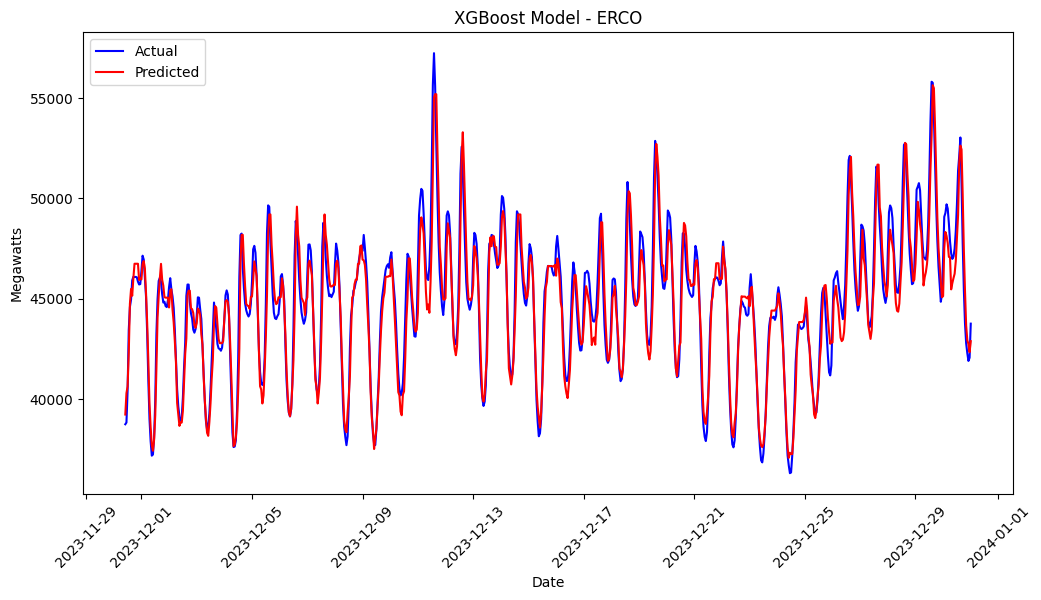

In [9]:
results(y_test, y_pred_xg, f"XGBoost Model - {respondent}")

RMSE: 972.70 MW


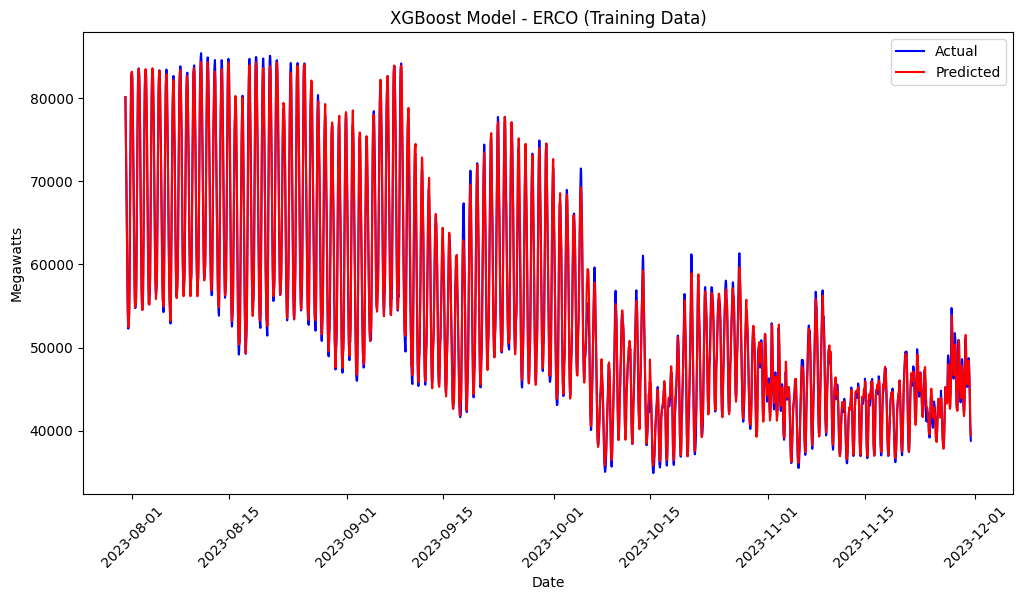

In [10]:
results(y_train, y_pred_train_xg, f"XGBoost Model - {respondent} (Training Data)")

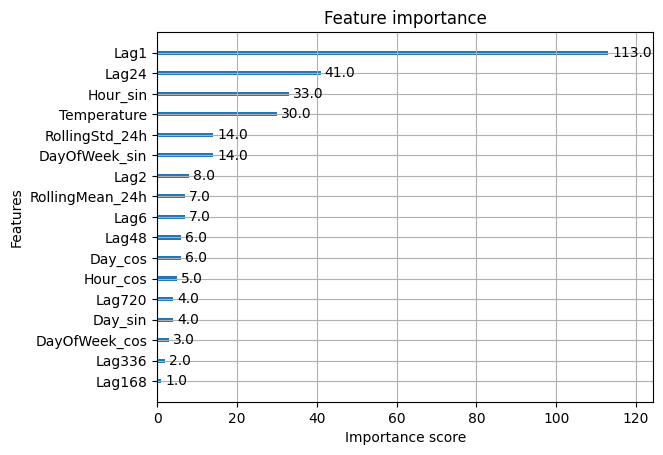

In [11]:
xgb.plot_importance(best_model)
plt.show()